In [29]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

from parcels import FieldSet, ParticleSet, ScipyParticle, JITParticle, ErrorCode, AdvectionRK4, Variable
from argparse import ArgumentParser
from datetime import timedelta
from datetime import datetime
import glob
import netCDF4 as netcdf
import matplotlib.pyplot as plt
import matplotlib as mpl
import cartopy
import cartopy.crs as ccrs
import xarray as xr
import cmocean
from timeit import default_timer as timer
import re
import pandas as pd
import sys

import os
from parcels import FieldSet, ParticleSet, ScipyParticle, JITParticle, ErrorCode, AdvectionRK4, Variable,ParticleFile, Field, VectorField
from kernels import  DeleteParticle, SampleIce, AdvectionRK4_ice, AdvectionRK4_ocean, AdvectionRK4_ice_sic, periodicBCC, IceOrOcean, AdvectionRK4_prob

from timeit import default_timer as timer
import math
import random




In [30]:
sys.path.insert(0,'.')    # '.' is in the same folder
%load_ext autoreload
%autoreload 1
#  Reload all modules imported with %aimport every time before executing the Python code typed.

%aimport plot_functions
%aimport backtrack_horizon
%aimport advect_ice_peeken


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [31]:
outdir = "/scratch/AnnekeV/output/peeken/"
out_jup = "/home/students/6252699/thesis/parcels2/output/"

# ==================================
# Main
# ==================================

In [32]:
# trajectory = ds.isel(traj=0)
# _ = backtrack_horizon.find_origin_layers_core(particle_trajectory= trajectory)

In [33]:
# npart = np.size(ds.lat,0)

In [34]:
names  = ["A", "B", "C", "D", "E", "Ha", "Hb", "Hc", "Hd"]
colors = ["blue", "red", "yellow", "lime", "orange", "lightpink", "purple", "turquoise", "powderblue"]

# ==================================
# Core data
# ==================================

In [35]:
df = pd.read_csv("cores.txt", delimiter="\t",index_col=0, header=0)
df

,Station ID,Sea ice type,Sample location,Sea ice origin,Campaign,Date,Latitude,Longitude
Core,,,,,,,,
A,PS85_426,Land-fast ice,Fram Strait,East Greenland,FRAM,14 June 2014,78.27,-14.71
B,PS85_472,Pack ice,Fram Strait,Makarov Basin,FRAM,25 June 2014,79.75,4.30
C,PS92_39,Pack ice,North of Svalbard,Deeper Nansen Basin,TRANSSIZ,11 June 2015,81.94,13.57
D,PS92_32,Pack ice,North of Svalbard,Franz Josef Land,TRANSSIZ,06 June 2015,81.24,19.43
E,PS94_54,Pack ice,Nansen Basin,Laptev Sea,TRANSARC_II,28 August 2015,85.09,42.61
Ha,Site_12,Land-fast ice,Chukchi Shelf,Chukchi Shelf,ICECAPE,21 June 2010,68.30,-166.98
Hb,Site_H11,Pack ice,Canadian Basin,Siberian Sea,HORTAX,29 August 2005,84.31,-149.06
Hc,Site_H3,Pack ice,Canadian Basin,Beaufort Gyre,HORTAX,18 August 2005,78.29,-176.68
Hd,Site_H26,Pack ice,Eurasian Basin,Laptev Sea,HORTAX,19 September 2005,88.06,58.75


In [36]:
years =  [2014, 2014, 2015, 2015, 2015, 2010, 2005, 2005, 2005]
months = [6, 6, 6, 6, 8 , 6, 8, 8, 9]
days   = [14, 25, 11, 6, 28, 21, 29, 18, 19]

dates = []
for i in range(9):
    dates.append(datetime(years[i], months[i], days[i]))

In [37]:
lons= [ -14.71   , 4.3   , 13.57 ,  19.43  , 42.61 ,-166.98 ,-149.06 ,-176.68 ,  58.75]
lats = [78.27, 79.75, 81.94, 81.24, 85.09, 68.3 , 84.31 ,78.29, 88.06]

In [38]:
years =  [2014, 2014, 2015, 2015, 2015, 2010, 2005, 2005, 2005]
months = [6, 6, 6, 6, 8 , 6, 8, 8, 9]
days   = [14, 25, 11, 6, 28, 21, 29, 18, 19]

dates = []
for i in range(9):
    dates.append(np.datetime64("{:4d}-{:02d}-{:02d}".format(years[i], months[i], days[i])))
time    = dates

In [39]:
names  = ["A", "B", "C", "D", "E", "Ha", "Hb", "Hc", "Hd"]
colors = ["blue", "red", "yellow", "lime", "orange", "lightpink", "purple", "turquoise", "powderblue"]

In [40]:
output_name_2015 = "/scratch/AnnekeV/output/peeken/06-06-one-of-3-peeken_npart_5_start_2015-10-01_simdays_2240_kernel_AdvectionRK4_prob_dt_days_1_year_2015"
output_name_2010 = "/scratch/AnnekeV/output/peeken/06-06-one-of-3-peeken_npart_1_start_2015-10-01_simdays_1510_kernel_AdvectionRK4_prob_dt_days_1_year_2010"
output_name_2005 = "/scratch/AnnekeV/output/peeken/06-06-one-of-3-peeken_npart_3_start_2015-10-01_simdays_1510_kernel_AdvectionRK4_prob_dt_days_1_year_2005"

output_name_2015 += ".nc"
output_name_2010 += ".nc"
output_name_2005 += ".nc"
fns = [output_name_2015, output_name_2010, output_name_2005]


0
1
2
3
4
5
6
7
8


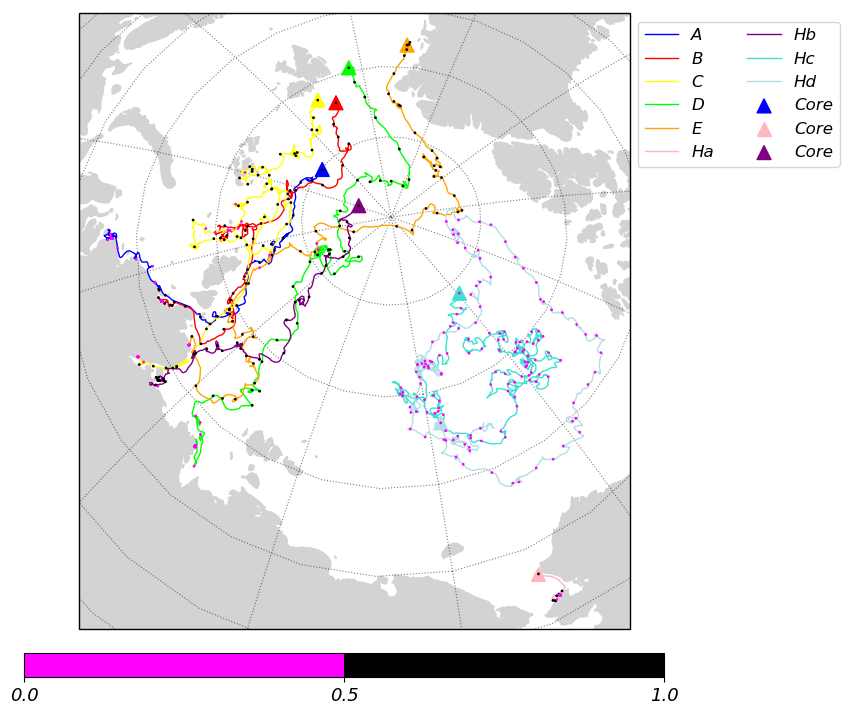

In [72]:
fns = [output_name_2015, output_name_2010, output_name_2005]



fig =plt.figure(figsize = [8,8])
ax = fig.add_subplot(1,1,1, projection=ccrs.NearsidePerspective(central_latitude =80, central_longitude=170, satellite_height = 4e6))
ax.add_feature(plot_functions.ocean_50m, facecolor="white")
ax.add_feature(plot_functions.land_50m, facecolor='lightgrey')
# ax.set_extent([-180,180,65,90],  ccrs.PlateCarree())
# plot_functions.set_circular_boundary(ax)
ax.gridlines(xlocs = np.arange(-180,185,30), ylocs = np.arange(0,95,5), color='black', alpha=0.5, linestyle=':')

bounds      = [0,.5,1.]
cmap        = plt.cm.Greys  # define the colormap
cmaplist    = [cmap(i) for i in range(cmap.N)]
cmaplist[0] = 'fuchsia'
cmap_custom = mpl.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, cmap.N)  # in case you want to edit a color

count = 0

for i in range(3):
    ds = xr.open_mfdataset(fns[i], decode_times=False)

    npart = np.size(ds.lat,0)
    nobs  = np.size(ds.lat,1)
    nobs  = 365*4
    obs_p = np.arange(0,nobs,20)
    for p in range(npart):
        print count
        
        
        ax.plot(ds.lon.isel(traj=p), ds.lat.isel(traj=p), transform=ccrs.Geodetic(), linewidth=1, color=colors[count], label=names[count])
        scat = ax.scatter(ds.lon.isel(traj=p).isel(obs=obs_p), ds.lat.isel(traj=p).isel(obs=obs_p), c=ds.in_ice.isel(traj=p).isel(obs=obs_p), transform=ccrs.PlateCarree(), s=1, label = None, zorder=20, cmap=cmap_custom)
        count+=1

    ax.scatter(ds.lon.isel(obs=0), ds.lat.isel(obs=0),  transform=ccrs.PlateCarree(), marker ='^', s=1e2, zorder=10, color=colors[count-npart:count], label= "Core")

plt.legend( ncol=2, loc='upper left', bbox_to_anchor=(1.0, 1.0))

'''create a second axes for the colorbar'''
norm        = mpl.colors.BoundaryNorm(bounds, cmap_custom.N)
ax_cbar     = fig.add_axes([ 0.1, 0.05,  0.8, 0.03])
cb          = mpl.colorbar.ColorbarBase(ax=ax_cbar, orientation = 'horizontal', cmap=cmap_custom, norm=norm, spacing='uniform', ticks=bounds, boundaries=bounds, format='%.1f')

In [90]:
ds = xr.open_dataset(output_name_2015, decode_times=False)

In [169]:
output_name_2015 = "/scratch/AnnekeV/output/peeken/06-06-one-of-3-peeken_npart_5_start_2015-10-01_simdays_2240_kernel_AdvectionRK4_prob_dt_days_1_year_2015"
output_name_2010 = "/scratch/AnnekeV/output/peeken/06-06-one-of-3-peeken_npart_1_start_2015-10-01_simdays_1510_kernel_AdvectionRK4_prob_dt_days_1_year_2010"
output_name_2005 = "/scratch/AnnekeV/output/peeken/06-06-one-of-3-peeken_npart_3_start_2015-10-01_simdays_1510_kernel_AdvectionRK4_prob_dt_days_1_year_2005"

output_name_2015 += ".nc"
output_name_2010 += ".nc"
output_name_2005 += ".nc"
fns = [output_name_2015, output_name_2010, output_name_2005]



In [214]:
ds1 = xr.open_mfdataset(fns[1:3], decode_times=False)
ds2 = xr.open_dataset(fns[0], decode_times=False)

In [221]:
nobs = np.arange(0,4*365+1)
ds3  = xr.concat([ds1.isel(obs=nobs), ds2.isel(obs=nobs)], dim='traj')
ds3.load()

<xarray.Dataset>
Dimensions:     (obs: 1461, traj: 9)
Dimensions without coordinates: obs, traj
Data variables:
    trajectory  (traj, obs) int32 5 5 5 5 5 5 5 5 5 5 5 ... 0 0 0 0 0 0 0 0 0 0
    time        (traj, obs) float64 2.987e+08 2.986e+08 ... 2.983e+08 2.982e+08
    lat         (traj, obs) float32 68.3 68.02912 67.83823 ... 76.65829 76.65829
    lon         (traj, obs) float32 -166.98 -166.2145 ... 111.333374 111.333374
    z           (traj, obs) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    sic         (traj, obs) float32 0.31074932 0.4936361 ... 1.7538461e-05
    in_ice      (traj, obs) float32 1.0 1.0 1.0 1.0 1.0 ... 0.0 0.0 0.0 0.0 0.0
    sit         (traj, obs) float32 0.81585306 0.9408386 ... 0.00028044434
Attributes:
    feature_type:           trajectory
    Conventions:            CF-1.6/CF-1.7
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_version:        2.0.0b0
    parcels_mesh:           spherical

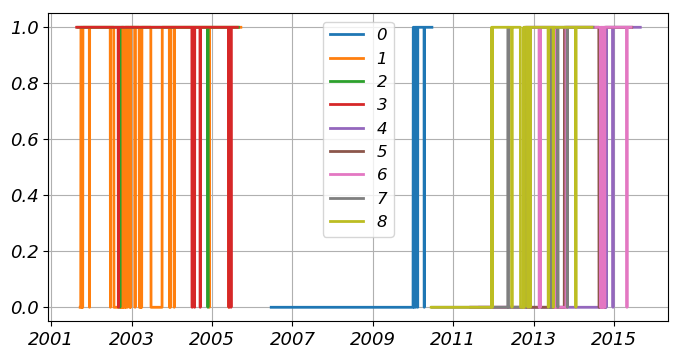

In [216]:
for i in range(9):
    
    
    p = ds3.isel(traj=i)
    time = p.time.astype( dtype='timedelta64[s]') + np.datetime64('2001-01-01T12:00') 
    plt.plot(time, p.in_ice, label=i)

plt.legend()

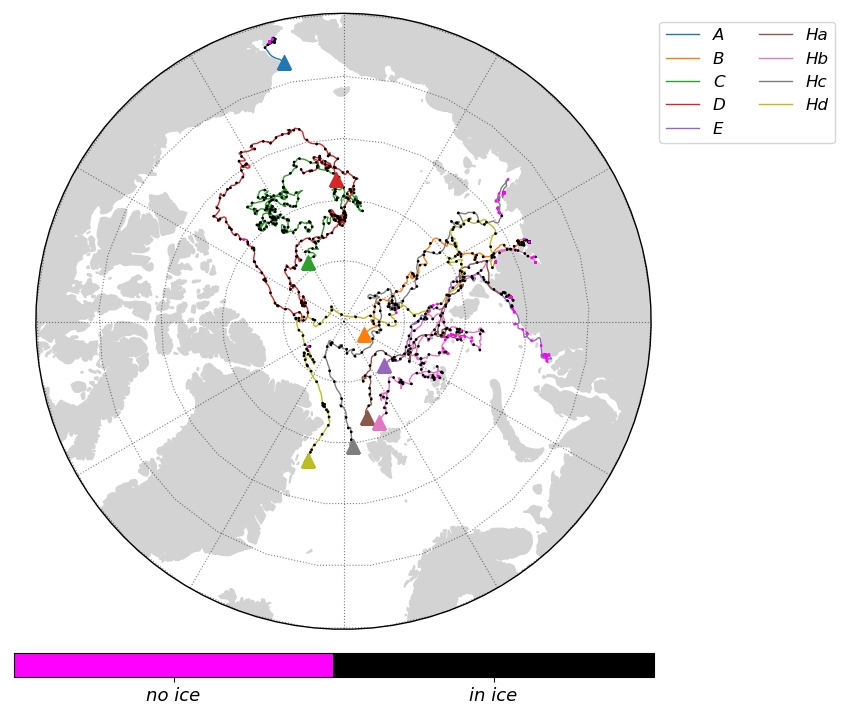

In [232]:
fns = [output_name_2015, output_name_2010, output_name_2005]



fig =plt.figure(figsize = [8,8])
ax = fig.add_subplot(1,1,1, projection=ccrs.NorthPolarStereo())
ax.add_feature(plot_functions.ocean_50m, facecolor="white")
ax.add_feature(plot_functions.land_50m, facecolor='lightgrey')
ax.set_extent([-180,180,65,90],  ccrs.PlateCarree())
plot_functions.set_circular_boundary(ax)
ax.gridlines(xlocs = np.arange(-180,185,30), ylocs = np.arange(0,95,5), color='black', alpha=0.5, linestyle=':')

bounds      = [0,.5,1.]
cmap        = plt.cm.Greys  # define the colormap
cmaplist    = [cmap(i) for i in range(cmap.N)]
cmaplist[0] = 'fuchsia'
cmap_custom = mpl.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, cmap.N)  # in case you want to edit a color

count = 0

ds3.in_ice[:,0] = 0


for i in range(9):
    p = ds3.isel(traj=i)

    ax.plot(p.lon, p.lat, transform=ccrs.Geodetic(), linewidth=1,  label=names[i])
    scat = ax.scatter(p.lon[::10], p.lat[::10], c=p.in_ice[::10], transform=ccrs.PlateCarree(), s=1, label = None, zorder=20, cmap=cmap_custom)

    ax.scatter(p.lon.isel(obs=0), p.lat.isel(obs=0),  transform=ccrs.PlateCarree(), marker ='^', s=1e2, zorder=30, label= None)

plt.legend( ncol=2, loc='upper left', bbox_to_anchor=(1.0, 1.0))

'''create a second axes for the colorbar'''
norm        = mpl.colors.BoundaryNorm(bounds, cmap_custom.N)
ax_cbar     = fig.add_axes([ 0.1, 0.05,  0.8, 0.03])
cb          = mpl.colorbar.ColorbarBase(ax=ax_cbar, orientation = 'horizontal', cmap=cmap_custom, norm=norm, spacing='uniform', boundaries=bounds, format='%.1f')
cb.set_ticks([0.25, 0.75])
cb.set_ticklabels(["no ice","in ice"])

In [234]:
where = np.where(p.in_ice==0)[0]
if len(where)>1:
    print where[1]

145


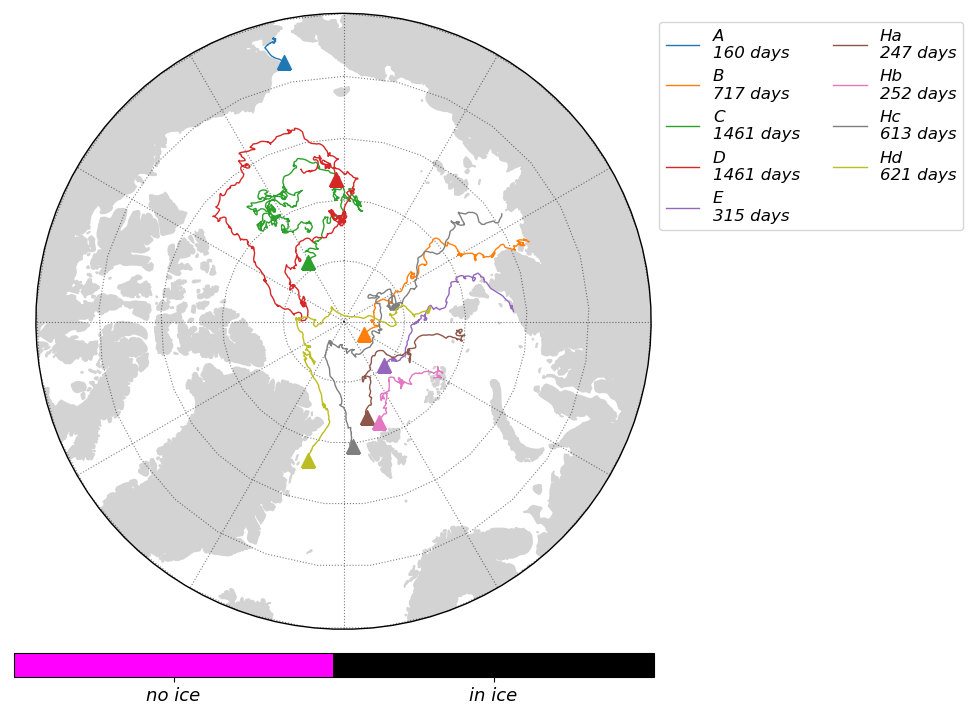

In [374]:
fns = [output_name_2015, output_name_2010, output_name_2005]

fig =plt.figure(figsize = [8,8])
ax = fig.add_subplot(1,1,1, projection=ccrs.NorthPolarStereo())
ax.add_feature(plot_functions.ocean_50m, facecolor="white")
ax.add_feature(plot_functions.land_50m, facecolor='lightgrey')
ax.set_extent([-180,180,65,90],  ccrs.PlateCarree())
plot_functions.set_circular_boundary(ax)
ax.gridlines(xlocs = np.arange(-180,185,30), ylocs = np.arange(0,95,5), color='black', alpha=0.5, linestyle=':')

bounds      = [0,.5,1.]
cmap        = plt.cm.Greys  # define the colormap
cmaplist    = [cmap(i) for i in range(cmap.N)]
cmaplist[0] = 'fuchsia'
cmap_custom = mpl.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, cmap.N)  # in case you want to edit a color

count = 0

ds3.in_ice[:,0] = 0


for i in range(9):
    p = ds3.isel(traj=i)
    where = np.where(p.sic<0.15)[0]
    mobs  = 1461
    if len(where)>1:
        mobs =  where[1]
    p = p.isel(obs=np.arange(mobs))

    ax.plot(p.lon, p.lat, transform=ccrs.Geodetic(), linewidth=1,  label="{}\n{} days".format(names[i], mobs))
#     scat = ax.scatter(p.lon[::10], p.lat[::10], c=p.in_ice[::10], transform=ccrs.PlateCarree(), s=1, label = None, zorder=20, cmap=cmap_custom)
    ax.scatter(p.lon.isel(obs=0), p.lat.isel(obs=0),  transform=ccrs.PlateCarree(), marker ='^', s=1e2, zorder=30, label= None)

plt.legend( ncol=2, loc='upper left', bbox_to_anchor=(1.0, 1.0))

'''create a second axes for the colorbar'''
norm        = mpl.colors.BoundaryNorm(bounds, cmap_custom.N)
ax_cbar     = fig.add_axes([ 0.1, 0.05,  0.8, 0.03])
cb          = mpl.colorbar.ColorbarBase(ax=ax_cbar, orientation = 'horizontal', cmap=cmap_custom, norm=norm, spacing='uniform', boundaries=bounds, format='%.1f')
cb.set_ticks([0.25, 0.75])
cb.set_ticklabels(["no ice","in ice"])

<xarray.DataArray 'sic' (traj: 9, obs: 1461)>
array([[3.107493e-01, 4.936361e-01, 6.869413e-01, ..., 0.000000e+00,
        9.544791e-05, 4.177242e-04],
       [9.901410e-01, 9.885109e-01, 9.854422e-01, ..., 1.192790e-02,
        2.396673e-02, 2.696261e-02],
       [9.634952e-01, 9.662429e-01, 9.707752e-01, ..., 9.463091e-01,
        9.455479e-01, 9.397203e-01],
       ...,
       [9.247568e-01, 9.285746e-01, 9.265379e-01, ..., 9.709647e-05,
        5.564816e-05, 1.073997e-05],
       [7.902272e-01, 8.019519e-01, 8.149030e-01, ..., 4.793983e-06,
        1.392076e-04, 3.439548e-04],
       [8.358566e-01, 8.484284e-01, 8.511308e-01, ..., 3.043427e-05,
        1.897784e-05, 1.753846e-05]], dtype=float32)
Dimensions without coordinates: traj, obs
Attributes:
    long_name:      
    standard_name:  sic
    units:          unknown


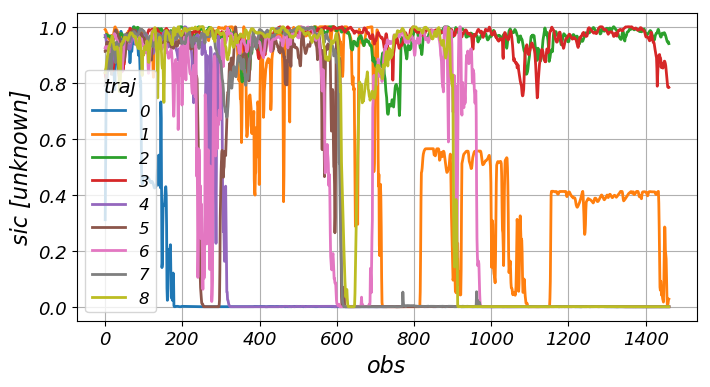

In [385]:
ds3.sic.plot.line(x='obs')
print ds3.sic


In [239]:
def IceOrOcean(particle, fieldset, time):
    if random.random() < math.atan((particle.sic*100)-15)/math.pi +.5  and particle.sic >.01:
        particle.in_ice = 1
    else:
        particle.in_ice = 0
    
    prev_sit = particle.sit

In [266]:
def IceOrOcean(particle, fieldset, time):
    
    # Previous state was in ice
    if particle.prev_state == 1:
        # If was in ice but now growing
        if particle.sit-particle.prev_sit > 0:
            particle.in_ice = 1
            
        # If was in ice but now melting
        else:
            # If melting but still above arctan
            if random.random() < math.atan((particle.sic*100)-15)/math.pi +.5  and particle.sic >.01:
                particle.in_ice = 1
            else:
                particle.in_ice = 0        
    
    # Previous state was in water
    else: 
        # If was in water but now growing
        if particle.sit-particle.prev_sit > 0:
            if random.random() < math.atan((particle.sic*100)-15)/math.pi +.5  and particle.sic >.01:
                particle.in_ice = 1
            else:
                particle.in_ice = 0
        # If was in water and now melting 
        else: 
            particle.in_ice = 0
            
    particle.prev_sit   = particle.sit
    particle.prev_state = particle.in_ice
    


In [425]:
class particle:
    def __init__(self, sic, sit, in_ice, prev_state, prev_sit):
        self.sic       = sic
        self.sit       = sit
        self.in_ice    = in_ice
        self.prev_state = prev_state
        self.prev_sit  = prev_sit
        
    def IceOrOcean(self):
        if self.prev_sit == np.nan:
            return selfin_ice == 0
        # Previous state was in ice
        elif self.prev_state == 1:
#             print("in ice")
            # If was in ice but now growing
            if self.sit-self.prev_sit >= 0:
#                 print('growing')
                self.in_ice = 1

            # If was in ice but now melting
            else:
                # If melting but still above arctan
                if random.random() < math.atan((self.sic*100)-15)/math.pi +.5  and self.sic >.01:
                    self.in_ice = 1
                else:
                    self.in_ice = 0        

        # Previous state was in water
        else: 
#             print('in water')
            # If was in water but now growing
            if self.sit-self.prev_sit >= 0:
#                 print('growing')
                if random.random() < math.atan((self.sic*100)-15)/math.pi +.5  and self.sic >.01:
                    self.in_ice = 1
                else:
                    self.in_ice = 0
            # If was in water and now melting 
            else: 
#                 print('melting')
                self.in_ice = 0

        self.prev_sit   = self.sit
        self.prev_state = self.in_ice
        
        return self.in_ice



In [426]:
sic = 0.20
sit = 1.
in_ice = 1
prev_state = 1
prev_sit = 0.5



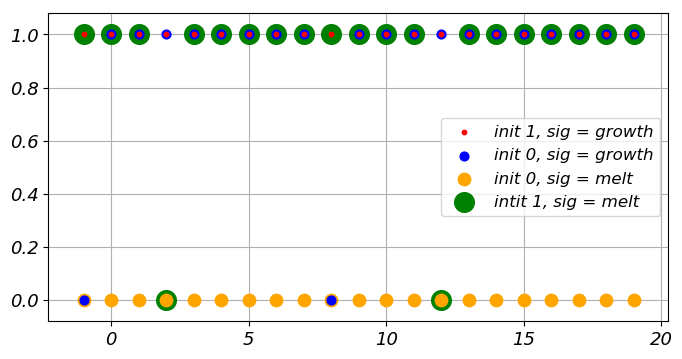

In [427]:
for i in range(20):

    p1 = particle(sic=sic, sit=1.,    in_ice=1, prev_state=1, prev_sit=.5)
    p2 = particle(sic=sic, sit=1.   , in_ice=0, prev_state=0, prev_sit=.5)
    p3 = particle(sic=sic, sit=.251, in_ice=0, prev_state=0, prev_sit=.5)
    p4 = particle(sic=sic, sit=.251, in_ice=1, prev_state=1, prev_sit=.5)
    p1_new_state = p1.IceOrOcean()
    p2_new_state = p2.IceOrOcean()
    p3_new_state = p3.IceOrOcean()
    p4_new_state = p4.IceOrOcean()

    plt.scatter(i, p1.in_ice, #label = "sic {}, sig = {}".format(p1.sic, p1.prev_sit-p1.sit) ,
                color = 'red', zorder = 40, s=10)
    
    plt.scatter(i, p2.in_ice, #label = "sic {}, sig = {}".format(p2.sic, p2.prev_sit-p2.sit) , 
                color = 'blue', zorder = 30, s=40)
    
    plt.scatter(i, p3.in_ice,# label = "sic {}, sig = {}".format(p3.sic, p3.prev_sit-p3.sit) , 
                color = 'orange', zorder = 20, s=80)

    plt.scatter(i, p4.in_ice, #label = "sic {}, sig = {}".format(p4.sic, p4.prev_sit-p4.sit) , 
                color = 'green', zorder = 10, s=200)

    

plt.scatter(-1, 1, label = "init {}, sig = {}".format(1, "growth") , color = 'red', zorder = 40, s=10)

plt.scatter(-1, 0, label = "init {}, sig = {}".format(0, "growth") , color = 'blue', zorder = 30, s=40)

plt.scatter(-1, 0, label = "init {}, sig = {}".format(0, "melt") , color = 'orange', zorder = 20, s=80)

plt.scatter(-1, 1, label = "intit {}, sig = {}".format(1, "melt") , color = 'green', zorder = 10, s=200)

plt.legend()


In [280]:
new_state

1